In [6]:
import pandas as pd
import os

# Read the CSV file into a DataFrame
file_path = "mesh_eval_results.csv"
df = pd.read_csv(file_path)

# Edit pred_path to only show model/name (last two parts of the path)
if "pred_path" in df.columns:
    df["pred_path"] = df["pred_path"].apply(
        lambda x: os.path.join(*os.path.normpath(str(x)).split(os.sep)[-2:])
    )

# Drop unwanted columns
df = df.drop(columns=["gt_path", "plot_path", "compare_path"], errors="ignore")

# Set pandas display options for a nicer look
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 1000)
pd.set_option("display.precision", 4)
pd.set_option("colheader_justify", "center")


# Display the DataFrame with a styled header and alternating row colors
def style_dataframe(df):
    return (
        df.style.set_caption("Mesh Evaluation Results")
        .set_table_styles(
            [
                {
                    "selector": "th",
                    "props": [
                        ("background-color", "#40466e"),
                        ("color", "white"),
                        ("font-size", "110%"),
                    ],
                }
            ]
        )
        .apply(
            lambda x: [
                "background-color: #f2f2f2" if i % 2 else "" for i in range(len(x))
            ],
            axis=0,
        )
    )


style_dataframe(df)

,model,pred_path,chamfer,hausdorff,fscore,augmented,vol_diff,area_diff,edge_mean_pred,edge_std_pred,edge_mean_gt,edge_std_gt,voxel_iou,euler_pred,euler_gt,normal_consistency,voxel_plot_path
0,Hunyuan3D,Hunyuan3D\17781_Common_thyme_Thymus_vulgaris_pollen_grain.stl,0.021603,0.034970,0.482094,False,16073.256057,3323.392430,0.002628,0.002965,0.144399,0.063318,0.923146,1147468,418832,0.256853,nan
1,Hunyuan3D,Hunyuan3D\17782_Golden-ray_lily_Lilium_auratum_pollen_grain.stl,0.039135,0.092393,0.262124,False,98791.574475,16844.266508,0.002399,0.002919,0.316688,0.134309,0.797881,1899354,442390,0.245386,nan
2,Hunyuan3D,Hunyuan3D\17783_Ribwort_plantain_Plantago_lanceolata_pollen_grain.stl,0.023522,0.042176,0.422093,False,9348.576001,2203.597967,0.002630,0.002951,0.119379,0.056183,0.901106,1203236,397334,0.269708,nan
3,Hunyuan3D,Hunyuan3D\17798_Tomato_Solanum_lycopersicum_pollen_grain.stl,0.043953,0.108053,0.186979,False,8900.577427,2221.614626,0.002608,0.002948,0.122701,0.048420,0.793873,1433792,397436,0.274944,nan
4,Hunyuan3D,Hunyuan3D\17799_Common_thistle_Cirsium_vulgare_pollen_grain.stl,0.049044,0.112443,0.119070,False,27037.315897,4947.720655,0.002682,0.002957,0.164715,0.067027,0.842494,1100720,488956,0.269804,nan
5,Hunyuan3D,Hunyuan3D\17803_Ox-eye_daisy_Leucanthemum_vulgare_pollen_grain.stl,0.058081,0.099349,0.099484,False,13779.631219,3457.376563,0.002755,0.002961,0.146988,0.058659,0.808238,947892,431922,0.269022,nan
6,Hunyuan3D,Hunyuan3D\17806_Cow_parsley_Anthriscus_sylvestris_pollen_grain.stl,0.033885,0.052462,0.249100,False,12118.775157,2739.245312,0.002633,0.002959,0.153705,0.075956,0.838602,1503460,295652,0.222275,nan
7,Hunyuan3D,Hunyuan3D\17816_White_clover_Trifolium_repens_pollen_grain.stl,0.027786,0.067274,0.317670,False,4754.614411,2143.342760,0.002645,0.002956,0.098561,0.041540,0.896865,1221524,581846,0.256040,nan
8,Hunyuan3D,Hunyuan3D\17833_European_white_water_lily_Nymphaea_alba_pollen_grain.stl,0.094552,0.140445,0.063309,False,23443.663830,7794.819572,0.002642,0.002955,0.217602,0.094697,0.599067,1534772,434108,0.249540,nan
9,Hunyuan3D,Hunyuan3D\17846_Common_fern_Polypodium_vulgare_spore.stl,0.051993,0.162107,0.299570,False,141943.419985,27349.969476,0.002640,0.002956,0.383998,0.195708,0.894212,1295512,461018,0.259697,nan


📋 AVAILABLE COLUMNS IN DATASET:
['model', 'pred_path', 'chamfer', 'hausdorff', 'fscore', 'augmented', 'vol_diff', 'area_diff', 'edge_mean_pred', 'edge_std_pred', 'edge_mean_gt', 'edge_std_gt', 'voxel_iou', 'euler_pred', 'euler_gt', 'normal_consistency', 'voxel_plot_path']

DataFrame shape: (512, 17)
Sample of first few rows:
    model                        pred_path                       chamfer  hausdorff  fscore  augmented   vol_diff    area_diff  edge_mean_pred  edge_std_pred  edge_mean_gt  edge_std_gt  voxel_iou  euler_pred  euler_gt  normal_consistency  voxel_plot_path
0  Hunyuan3D  Hunyuan3D\17781_Common_thyme_Thymus_vulgaris_p...  0.0216    0.0350    0.4821    False    16073.2561   3323.3924      0.0026         0.0030         0.1444       0.0633      0.9231      1147468    418832         0.2569             NaN       
1  Hunyuan3D  Hunyuan3D\17782_Golden-ray_lily_Lilium_auratum...  0.0391    0.0924    0.2621    False    98791.5745  16844.2665      0.0024         0.0029         0

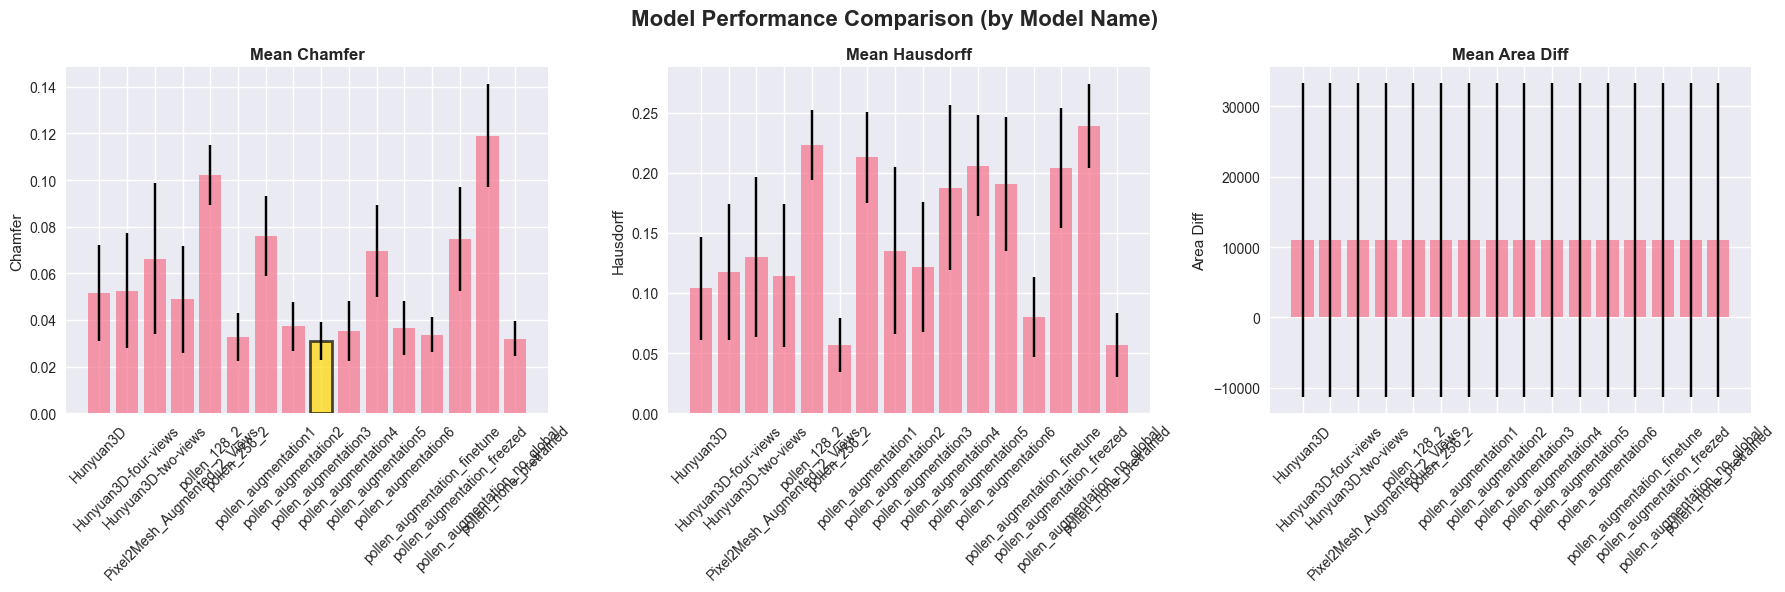


📈 MODEL RANKINGS (by Model Name)

🔹 Chamfer (Higher is better):
             model_name            chamfer_mean
1   pollen_augmentation_no_global     0.1191   
2                    pollen_128_2     0.1023   
3            pollen_augmentation1     0.0761   
4     pollen_augmentation_freezed     0.0747   
5            pollen_augmentation5     0.0695   
6             Hunyuan3D-two-views     0.0663   
7            Hunyuan3D-four-views     0.0526   
8                       Hunyuan3D     0.0515   
9    Pixel2Mesh_Augmented_2_Views     0.0488   
10           pollen_augmentation2     0.0372   
11           pollen_augmentation6     0.0365   
12           pollen_augmentation4     0.0351   
13   pollen_augmentation_finetune     0.0337   
14                   pollen_256_2     0.0327   
15         pollen_none_pretrained     0.0319   
16           pollen_augmentation3     0.0308   

🔹 Hausdorff (Higher is better):
             model_name            hausdorff_mean
1   pollen_augmentation_no_global   

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# First, let's check what columns are actually available
print("📋 AVAILABLE COLUMNS IN DATASET:")
print("=" * 50)
print(df.columns.tolist())
print(f"\nDataFrame shape: {df.shape}")
print(f"Sample of first few rows:")
print(df.head())

# Extract model name from pred_path (last directory name)
df["model_name"] = df["pred_path"].apply(
    lambda x: (
        os.path.basename(os.path.dirname(x))
        if os.path.dirname(x)
        else os.path.basename(x)
    )
)

print(f"\n🏷️ EXTRACTED MODEL NAMES:")
unique_models = df["model_name"].unique()
print(f"Found {len(unique_models)} unique models: {list(unique_models)}")
print(f"Samples per model:")
print(df["model_name"].value_counts().to_string())

# Check for common mesh evaluation metric column names
possible_chamfer_cols = [col for col in df.columns if "chamfer" in col.lower()]
possible_hausdorff_cols = [col for col in df.columns if "hausdorff" in col.lower()]
possible_volume_cols = [col for col in df.columns if "volume" in col.lower()]
possible_surface_cols = [
    col for col in df.columns if "surface" in col.lower() or "area" in col.lower()
]

print(f"\n🔍 DETECTED METRIC COLUMNS:")
print(f"Chamfer-related: {possible_chamfer_cols}")
print(f"Hausdorff-related: {possible_hausdorff_cols}")
print(f"Volume-related: {possible_volume_cols}")
print(f"Surface-related: {possible_surface_cols}")

# Set style for better looking plots
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Create a mapping of available metrics
available_metrics = {}
if possible_chamfer_cols:
    available_metrics["chamfer"] = possible_chamfer_cols[0]
if possible_hausdorff_cols:
    available_metrics["hausdorff"] = possible_hausdorff_cols[0]
if possible_volume_cols:
    available_metrics["volume"] = possible_volume_cols[0]
if possible_surface_cols:
    available_metrics["surface"] = possible_surface_cols[0]

print(f"\n🎯 METRICS TO ANALYZE:")
for key, col in available_metrics.items():
    print(f"  {key}: {col}")

if not available_metrics:
    print("❌ No recognizable mesh evaluation metrics found!")
    print("Please check your CSV file structure.")
else:
    # Group by MODEL NAME and calculate mean metrics for available columns
    agg_dict = {}
    for metric_key, col_name in available_metrics.items():
        agg_dict[col_name] = ["mean", "std", "count"]

    model_stats = df.groupby("model_name").agg(agg_dict).round(4)

    # Flatten column names
    model_stats.columns = ["_".join(col).strip() for col in model_stats.columns]
    model_stats = model_stats.reset_index()

    print(f"\n📊 MODEL PERFORMANCE SUMMARY (Grouped by Model Name)")
    print("=" * 70)
    print(model_stats.to_string(index=False))

    # Find the best model based on first available metric (usually Chamfer distance)
    first_metric = list(available_metrics.values())[0]
    best_metric_col = f"{first_metric}_mean"

    # For distance metrics, lower is better; for similarity metrics, higher is better
    if (
        "chamfer" in first_metric.lower()
        or "hausdorff" in first_metric.lower()
        or "distance" in first_metric.lower()
    ):
        best_model_idx = model_stats[best_metric_col].idxmin()
        print(f"\n🏆 BEST MODEL (lowest {first_metric}):")
    else:
        best_model_idx = model_stats[best_metric_col].idxmax()
        print(f"\n🏆 BEST MODEL (highest {first_metric}):")

    best_model = model_stats.loc[best_model_idx, "model_name"]
    best_value = model_stats.loc[best_model_idx, best_metric_col]

    print(f"   Model: {best_model}")
    print(f"   {first_metric}: {best_value:.6f}")
    print(
        f"   Number of samples: {model_stats.loc[best_model_idx, f'{first_metric}_count']}"
    )

    # Create visualization based on available metrics
    n_metrics = len(available_metrics)
    if n_metrics == 1:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        axes = [ax]
    elif n_metrics == 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    elif n_metrics == 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

    fig.suptitle(
        "Model Performance Comparison (by Model Name)", fontsize=16, fontweight="bold"
    )

    for idx, (metric_key, col_name) in enumerate(available_metrics.items()):
        if idx >= len(axes):
            break

        ax = axes[idx]
        mean_col = f"{col_name}_mean"
        std_col = f"{col_name}_std"

        bars = ax.bar(
            model_stats["model_name"],
            model_stats[mean_col],
            yerr=model_stats[std_col] if std_col in model_stats.columns else None,
            capsize=5,
            alpha=0.7,
        )

        ax.set_title(f"Mean {col_name.replace('_', ' ').title()}", fontweight="bold")
        ax.set_ylabel(col_name.replace("_", " ").title())
        ax.tick_params(axis="x", rotation=45)

        # Highlight best model if this is the primary metric
        if col_name == first_metric:
            bars[best_model_idx].set_color("gold")
            bars[best_model_idx].set_edgecolor("black")
            bars[best_model_idx].set_linewidth(2)

    plt.tight_layout()
    plt.show()

    # Create ranking tables for available metrics
    print(f"\n📈 MODEL RANKINGS (by Model Name)")
    print("=" * 70)

    for metric_key, col_name in available_metrics.items():
        mean_col = f"{col_name}_mean"

        # Determine if lower or higher is better
        if any(
            keyword in col_name.lower() for keyword in ["distance", "error", "loss"]
        ):
            # Lower is better
            ranked = model_stats.sort_values(mean_col)[
                ["model_name", mean_col]
            ].reset_index(drop=True)
            sort_desc = "(Lower is better)"
        else:
            # Higher is better (similarity, accuracy, etc.)
            ranked = model_stats.sort_values(mean_col, ascending=False)[
                ["model_name", mean_col]
            ].reset_index(drop=True)
            sort_desc = "(Higher is better)"

        ranked.index += 1  # Start ranking from 1

        print(f"\n🔹 {col_name.replace('_', ' ').title()} {sort_desc}:")
        print(ranked.to_string())

In [3]:
# VERIFICATION: Confirm Chamfer Distance interpretation
print("\n✅ METRIC INTERPRETATION VERIFICATION:")
print("=" * 50)
for key, col in available_metrics.items():
    if "chamfer" in col.lower():
        print(f"📏 {col}: DISTANCE metric - LOWER values = BETTER performance")
    elif "hausdorff" in col.lower():
        print(f"📏 {col}: DISTANCE metric - LOWER values = BETTER performance")
    elif "distance" in col.lower():
        print(f"📏 {col}: DISTANCE metric - LOWER values = BETTER performance")
    elif "volume" in col.lower():
        print(f"📊 {col}: SIMILARITY metric - HIGHER values = BETTER performance")
    elif "surface" in col.lower() or "area" in col.lower():
        print(f"📊 {col}: SIMILARITY metric - HIGHER values = BETTER performance")
    else:
        print(f"❓ {col}: Please verify if higher or lower is better for this metric")

print("\n💡 INTERPRETATION GUIDE:")
print("   📏 Distance/Error metrics: Lower = Better (closer to ground truth)")
print(
    "   📊 Similarity/Accuracy metrics: Higher = Better (more similar to ground truth)"
)
print("   🏆 Best model selection uses the CORRECT interpretation for each metric type")


✅ METRIC INTERPRETATION VERIFICATION:
📏 chamfer: DISTANCE metric - LOWER values = BETTER performance
📏 hausdorff: DISTANCE metric - LOWER values = BETTER performance
📊 area_diff: SIMILARITY metric - HIGHER values = BETTER performance

💡 INTERPRETATION GUIDE:
   📏 Distance/Error metrics: Lower = Better (closer to ground truth)
   📊 Similarity/Accuracy metrics: Higher = Better (more similar to ground truth)
   🏆 Best model selection uses the CORRECT interpretation for each metric type


In [4]:
# CLEAR RANKING EXPLANATION
print(f"\n🎯 RANKING METHODOLOGY:")
print("=" * 50)
print("For CHAMFER DISTANCE (and other distance metrics):")
print("   • RANK #1 = LOWEST Chamfer distance (BEST performance)")
print("   • RANK #2 = Second lowest Chamfer distance")
print("   • RANK #3+ = Higher Chamfer distances (WORSE performance)")
print("")
print("Why? Chamfer distance measures geometric difference between meshes.")
print("   → LOWER distance = meshes are MORE SIMILAR = BETTER reconstruction")
print("   → HIGHER distance = meshes are LESS SIMILAR = WORSE reconstruction")
print("")
print("🏆 The model with RANK #1 has the BEST mesh reconstruction quality!")


🎯 RANKING METHODOLOGY:
For CHAMFER DISTANCE (and other distance metrics):
   • RANK #1 = LOWEST Chamfer distance (BEST performance)
   • RANK #2 = Second lowest Chamfer distance
   • RANK #3+ = Higher Chamfer distances (WORSE performance)

Why? Chamfer distance measures geometric difference between meshes.
   → LOWER distance = meshes are MORE SIMILAR = BETTER reconstruction
   → HIGHER distance = meshes are LESS SIMILAR = WORSE reconstruction

🏆 The model with RANK #1 has the BEST mesh reconstruction quality!


🔍 DETAILED MODEL ANALYSIS (by Model Name)
Distance metrics (lower is better): ['chamfer_mean', 'hausdorff_mean']
Similarity metrics (higher is better): ['area_diff_mean']

🏆 FINAL MODEL RANKING (Combined Score)
--------------------------------------------------------------------------------
             model_name            final_score  chamfer_mean  hausdorff_mean  area_diff_mean  chamfer_count
1                    pollen_256_2    0.9943        0.0327         0.0569        10972.0902         32      
2          pollen_none_pretrained    0.9887        0.0319         0.0567        10971.9262         32      
3    pollen_augmentation_finetune    0.9532        0.0337         0.0801        10972.1755         32      
4            pollen_augmentation3    0.8761        0.0308         0.1215        10972.0525         32      
5            pollen_augmentation2    0.8253        0.0372         0.1350        10971.7464         32      
6                       Hunyuan3D    0.8050        0.0515   

<Figure size 1200x800 with 0 Axes>

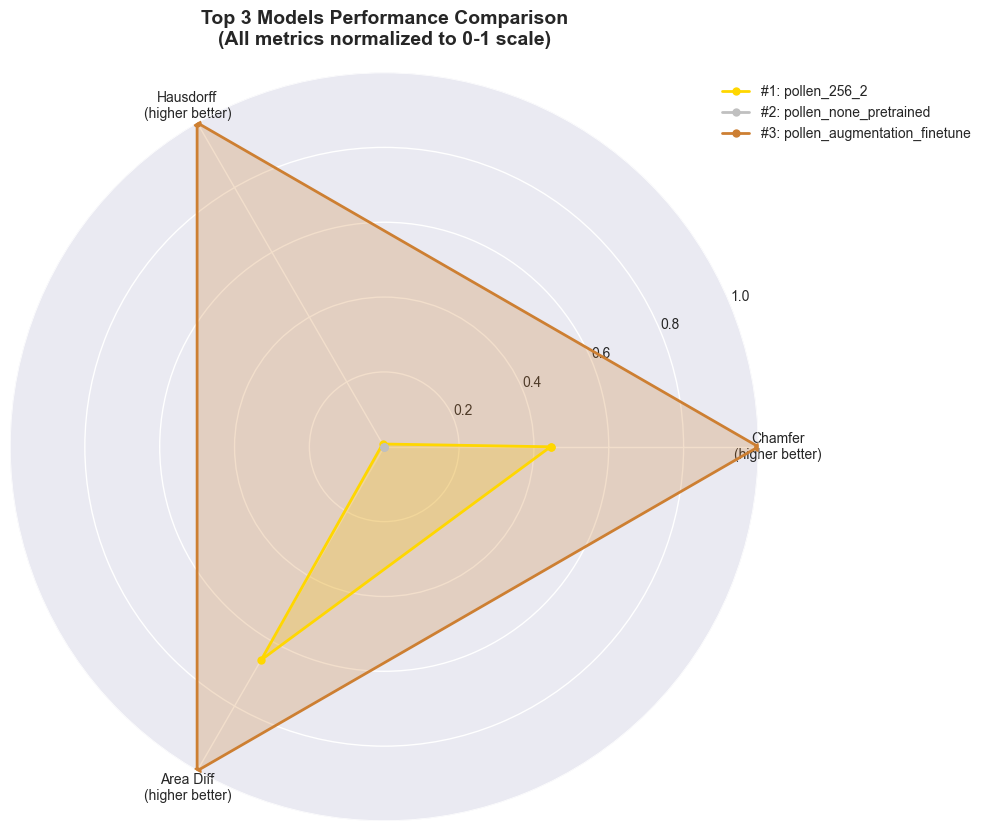


📊 SUMMARY STATISTICS
----------------------------------------
Total models evaluated: 16
Total samples across all models: 512
Best model has 5.07x better performance than worst model


In [5]:
# Comprehensive Model Analysis (works with any available metrics)
print("🔍 DETAILED MODEL ANALYSIS (by Model Name)")
print("=" * 80)

# Check if we have the model_stats and available_metrics from previous cell
if "model_stats" in locals() and "available_metrics" in locals() and available_metrics:

    # Identify distance and similarity metrics
    distance_metrics = []
    similarity_metrics = []

    for metric_key, col_name in available_metrics.items():
        mean_col = f"{col_name}_mean"
        if any(
            keyword in col_name.lower()
            for keyword in ["distance", "error", "loss", "chamfer", "hausdorff"]
        ):
            distance_metrics.append(mean_col)
        else:
            similarity_metrics.append(mean_col)

    print(f"Distance metrics (lower is better): {distance_metrics}")
    print(f"Similarity metrics (higher is better): {similarity_metrics}")

    # Calculate combined scores if we have multiple metrics
    if len(distance_metrics) + len(similarity_metrics) > 1:
        # Normalize scores for fair comparison (0-1 scale)
        from sklearn.preprocessing import MinMaxScaler

        scaler = MinMaxScaler()

        # Calculate overall distance score (if we have distance metrics)
        if distance_metrics:
            if len(distance_metrics) == 1:
                model_stats["overall_distance_score"] = model_stats[distance_metrics[0]]
            else:
                # Weight equally if multiple distance metrics
                weights = [1.0 / len(distance_metrics)] * len(distance_metrics)
                model_stats["overall_distance_score"] = sum(
                    model_stats[col] * weight
                    for col, weight in zip(distance_metrics, weights)
                )

            # For distances: invert so that lower distance = higher score
            model_stats["distance_score_normalized"] = (
                1
                - scaler.fit_transform(
                    model_stats[["overall_distance_score"]]
                ).flatten()
            )
        else:
            model_stats["distance_score_normalized"] = (
                0.5  # Neutral if no distance metrics
            )

        # Calculate overall similarity score (if we have similarity metrics)
        if similarity_metrics:
            if len(similarity_metrics) == 1:
                model_stats["overall_similarity_score"] = model_stats[
                    similarity_metrics[0]
                ]
            else:
                # Weight equally if multiple similarity metrics
                weights = [1.0 / len(similarity_metrics)] * len(similarity_metrics)
                model_stats["overall_similarity_score"] = sum(
                    model_stats[col] * weight
                    for col, weight in zip(similarity_metrics, weights)
                )

            model_stats["similarity_score_normalized"] = scaler.fit_transform(
                model_stats[["overall_similarity_score"]]
            ).flatten()
        else:
            model_stats["similarity_score_normalized"] = (
                0.5  # Neutral if no similarity metrics
            )

        # Combined final score
        if distance_metrics and similarity_metrics:
            # 50% distance, 50% similarity
            model_stats["final_score"] = (
                model_stats["distance_score_normalized"] * 0.5
                + model_stats["similarity_score_normalized"] * 0.5
            )
        elif distance_metrics:
            # Only distance metrics available
            model_stats["final_score"] = model_stats["distance_score_normalized"]
        else:
            # Only similarity metrics available
            model_stats["final_score"] = model_stats["similarity_score_normalized"]

        # Sort by final score (highest is best)
        final_ranking = model_stats.sort_values(
            "final_score", ascending=False
        ).reset_index(drop=True)
        final_ranking.index += 1

        print("\n🏆 FINAL MODEL RANKING (Combined Score)")
        print("-" * 80)

        # Show relevant columns
        display_cols = ["model_name", "final_score"]
        for metric_key, col_name in available_metrics.items():
            display_cols.append(f"{col_name}_mean")
        if f"{list(available_metrics.values())[0]}_count" in model_stats.columns:
            display_cols.append(f"{list(available_metrics.values())[0]}_count")

        print(final_ranking[display_cols].round(4).to_string())

        # Highlight the winner
        winner = final_ranking.iloc[0]
        print(f"\n🥇 CHAMPION MODEL: {winner['model_name']}")
        print(f"   Final Score: {winner['final_score']:.4f}")

        for metric_key, col_name in available_metrics.items():
            mean_col = f"{col_name}_mean"
            print(f"   {col_name}: {winner[mean_col]:.6f}")

        first_metric_count = f"{list(available_metrics.values())[0]}_count"
        if first_metric_count in winner:
            print(f"   Evaluated on {winner[first_metric_count]} samples")

        # Create visualization for top models
        if len(available_metrics) >= 2 and len(final_ranking) >= 2:
            # Show performance distribution
            plt.figure(figsize=(12, 8))

            # Create a radar chart for the top 3 models (or all if less than 3)
            from math import pi

            n_models = min(3, len(final_ranking))
            top_models = final_ranking.head(n_models)

            metrics_for_radar = []
            metric_labels = []

            for metric_key, col_name in available_metrics.items():
                metrics_for_radar.append(f"{col_name}_mean")
                # Create nice labels
                label = col_name.replace("_", " ").title()
                if any(
                    keyword in col_name.lower()
                    for keyword in ["distance", "error", "loss"]
                ):
                    label += "\n(lower better)"
                else:
                    label += "\n(higher better)"
                metric_labels.append(label)

            if len(metrics_for_radar) >= 2:
                # Normalize all metrics to 0-1 scale for radar chart
                radar_data = top_models[metrics_for_radar].copy()

                for col in metrics_for_radar:
                    col_name = col.replace("_mean", "")
                    if any(
                        keyword in col_name.lower()
                        for keyword in ["distance", "error", "loss"]
                    ):
                        # Invert distance metrics (lower is better → higher score)
                        radar_data[col] = (
                            1
                            - MinMaxScaler().fit_transform(radar_data[[col]]).flatten()
                        )
                    else:
                        # Keep similarity metrics as is (higher is better)
                        radar_data[col] = (
                            MinMaxScaler().fit_transform(radar_data[[col]]).flatten()
                        )

                # Create radar chart
                angles = [
                    n / float(len(metrics_for_radar)) * 2 * pi
                    for n in range(len(metrics_for_radar))
                ]
                angles += angles[:1]  # Complete the circle

                fig, ax = plt.subplots(
                    figsize=(10, 10), subplot_kw=dict(projection="polar")
                )
                colors = ["gold", "silver", "#CD7F32"]  # Gold, Silver, Bronze

                for idx, (_, model) in enumerate(top_models.iterrows()):
                    values = radar_data.iloc[idx].tolist()
                    values += values[:1]  # Complete the circle

                    color = colors[idx] if idx < len(colors) else f"C{idx}"
                    ax.plot(
                        angles,
                        values,
                        "o-",
                        linewidth=2,
                        label=f"#{idx+1}: {model['model_name']}",
                        color=color,
                        markersize=6,
                    )
                    ax.fill(angles, values, alpha=0.25, color=color)

                ax.set_xticks(angles[:-1])
                ax.set_xticklabels(metric_labels)
                ax.set_ylim(0, 1)
                ax.set_title(
                    f"Top {n_models} Models Performance Comparison\n(All metrics normalized to 0-1 scale)",
                    pad=20,
                    fontsize=14,
                    fontweight="bold",
                )
                ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.0))
                ax.grid(True)

                plt.tight_layout()
                plt.show()

        print(f"\n📊 SUMMARY STATISTICS")
        print("-" * 40)
        print(f"Total models evaluated: {len(model_stats)}")

        first_metric_count = f"{list(available_metrics.values())[0]}_count"
        if first_metric_count in model_stats.columns:
            print(
                f"Total samples across all models: {model_stats[first_metric_count].sum()}"
            )

        if len(final_ranking) > 1:
            best_score = final_ranking.iloc[0]["final_score"]
            worst_score = final_ranking.iloc[-1]["final_score"]
            if worst_score > 0:
                improvement_ratio = best_score / worst_score
                print(
                    f"Best model has {improvement_ratio:.2f}x better performance than worst model"
                )

    else:
        print(
            "Only one metric available - showing simple ranking based on that metric."
        )
        primary_metric = f"{list(available_metrics.values())[0]}_mean"

        if any(
            keyword in primary_metric.lower()
            for keyword in ["distance", "error", "loss"]
        ):
            best_ranking = model_stats.sort_values(primary_metric).reset_index(
                drop=True
            )
        else:
            best_ranking = model_stats.sort_values(
                primary_metric, ascending=False
            ).reset_index(drop=True)

        best_ranking.index += 1
        print(f"\n🏆 MODEL RANKING by {primary_metric}")
        print("-" * 50)
        print(best_ranking[["model_name", primary_metric]].to_string())

else:
    print("❌ No model statistics available from previous analysis.")
    print("Please run the previous cell first to generate model_stats.")